In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torch import nn
mse = nn.MSELoss()


np.random.seed(42)

In [46]:
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)
df = pd.DataFrame({'value': ARMA_1_1})

train = df[:800]
test = df[800:]

In [47]:
def optimize_ARMA_Order(endog: Union[pd.Series, list], order_list: list) -> tuple:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    pq = result_df.head(1)['(p,q)'].item()
    
    return (pq[0], 0, pq[1] )

In [48]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, order = (0,0,0)) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=order)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [49]:

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
order_list = list(product(range(0, 4, 1), range(0, 4, 1)))

In [51]:

result_df = optimize_ARMA(train['value'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2248.963612
1,"(0, 3)",2250.254599
2,"(2, 1)",2250.542525
3,"(3, 3)",2250.575794
4,"(1, 2)",2250.634090
5,"(3, 1)",2251.608926
6,"(1, 3)",2251.665095
7,"(2, 2)",2252.132951
8,"(2, 3)",2252.260993
9,"(3, 2)",2253.514774


In [52]:
order = optimize_ARMA_Order(train['value'], order_list)
order

  0%|          | 0/16 [00:00<?, ?it/s]

(1, 0, 1)

In [53]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA', order)

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_ARMA'] = pred_ARMA

test.head(5)

,value,pred_mean,pred_last_value,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.021287,1.084218,1.183808
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020556,-0.141873,0.062876
804,-0.989997,-0.021056,-0.422585,-0.571610


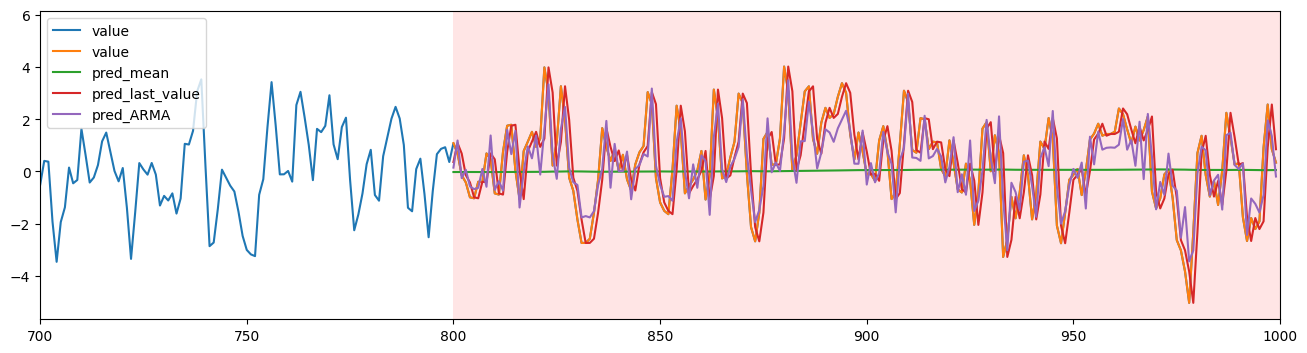

In [54]:
ax = df.plot( figsize=(16,4),  layout='constrained' )
test.plot( ax = ax)
ax.set_xlim(700, 1000)
ax.axvspan(800, 1000, facecolor='red', alpha=0.1)
plt.show()

In [55]:
loss = {}
loss['mean'] =  mse( torch.FloatTensor( test['pred_mean'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test['pred_last_value'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss['arma'] =  mse( torch.FloatTensor( test['pred_ARMA'][:].values),  torch.FloatTensor(test['value'][:].values) ).item()
loss

{'mean': 2.679252862930298,
 'last_value': 1.6761456727981567,
 'arma': 0.9281958937644958}

In [81]:
np.random.seed(42)
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, -0.33, -0.50])

ARMA_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)
ARMA_2_2_result = adfuller(ARMA_2_2)
ARMA_2_2_result

(-20.684894435243248,
 0.0,
 5,
 9994,
 {'1%': -3.4310044907347454,
  '5%': -2.8618292459530794,
  '10%': -2.566923960483154},
 28346.42845135377)

In [82]:
df_2 = pd.DataFrame({'value': ARMA_2_2})

train_2 = df_2[:-200]
test_2 = df_2[-200:]


In [84]:
order_list = list(product(range(1, 4, 1), range(1, 4, 1)))
order_2 = optimize_ARMA_Order(train_2['value'], order_list)
order_2

  0%|          | 0/9 [00:00<?, ?it/s]

(3, 0, 2)

In [85]:
model = SARIMAX(train_2['value'], order=order_2, simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 9800
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -13946.551
Date:                Mon, 12 Aug 2024   AIC                          27905.102
Time:                        15:57:47   BIC                          27948.243
Sample:                             0   HQIC                         27919.719
                               - 9800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3517      0.053      6.625      0.000       0.248       0.456
ar.L2          0.4169      0.067      6.267      0.000       0.286       0.547
ar.L3          0.0539      0.036      1.508      0.1

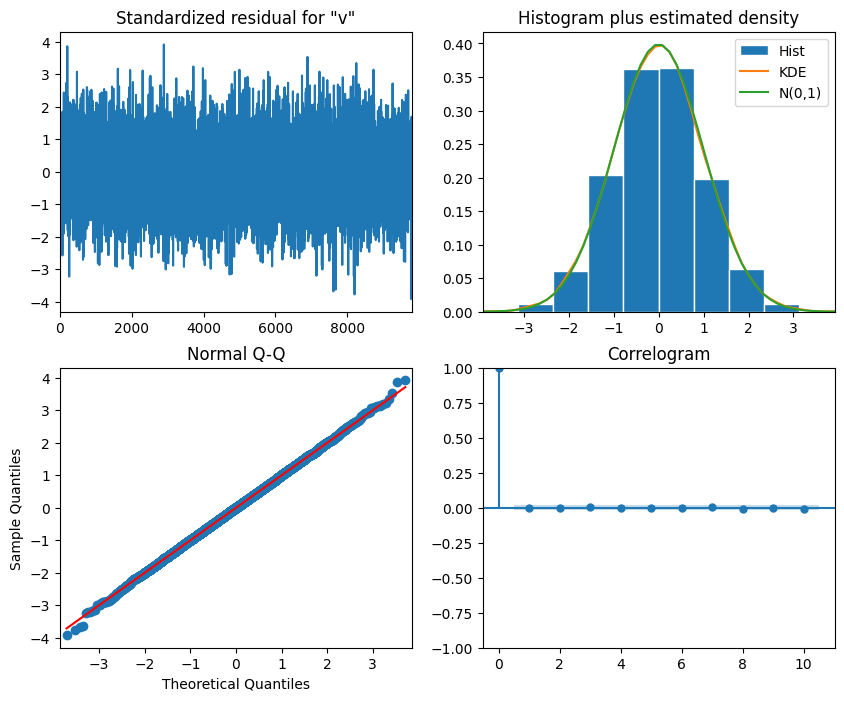

In [86]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [87]:
tr = acorr_ljungbox(model_fit.resid, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.000576   0.980855
2   0.013376   0.993334
3   0.041247   0.997799
4   0.081312   0.999196
5   0.330909   0.997021
6   0.378716   0.999018
7   0.470024   0.999549
8   1.277162   0.995819
9   1.296439   0.998394
10  1.755217   0.997895


In [88]:

TRAIN_LEN = len(train_2)
HORIZON = len(test_2)
WINDOW = 2

pred_mean = rolling_forecast(df_2, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_2, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_2, TRAIN_LEN, HORIZON, WINDOW, 'ARMA', order_2)

test_2['pred_mean'] = pred_mean
test_2['pred_last_value'] = pred_last_value
test_2['pred_ARMA'] = pred_ARMA

test_2.head(5)

,value,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.179761
9801,0.479336,-0.025645,-0.837188,-1.128602
9802,3.059285,-0.025619,0.479336,0.742030
9803,2.459694,-0.025619,0.479336,0.611575
9804,2.941582,-0.025051,2.459694,2.089136


In [92]:
test_2['pred_ARMA'] = rolling_forecast(df_2, TRAIN_LEN, HORIZON, WINDOW, 'ARMA', (2,0,2))

In [93]:
test_2.head(5)

,value,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.182182
9801,0.479336,-0.025645,-0.837188,-1.137223
9802,3.059285,-0.025619,0.479336,0.736508
9803,2.459694,-0.025619,0.479336,0.627930
9804,2.941582,-0.025051,2.459694,2.100925


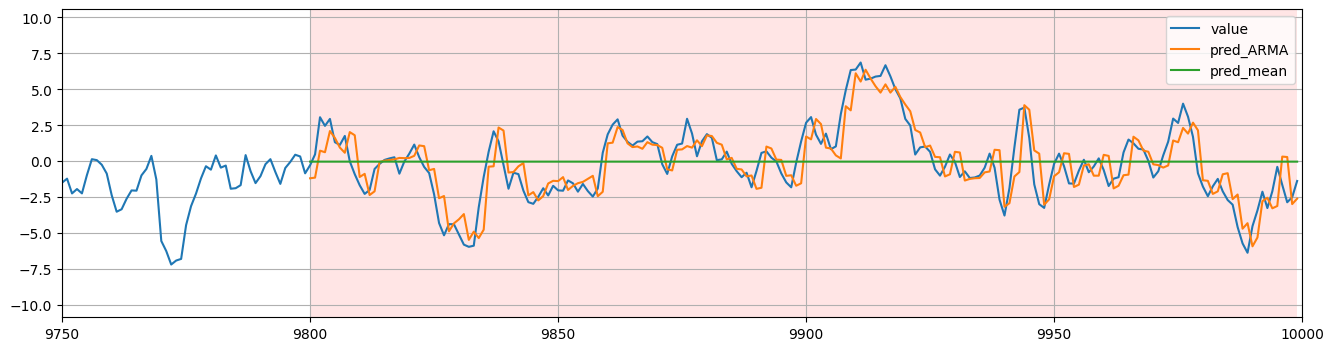

In [98]:
ax = df_2.plot( figsize=(16,4),  layout='constrained' )
test_2[['pred_ARMA', 'pred_mean']].plot( ax = ax)
ax.set_xlim(9750, 10000)
ax.grid()
ax.axvspan(9800, 9999, facecolor='red', alpha=0.1)
plt.show()

In [96]:
loss = {}
loss['mean'] =  mse( torch.FloatTensor( test_2['pred_mean'][:].values),  torch.FloatTensor(test_2['value'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test_2['pred_last_value'][:].values),  torch.FloatTensor(test_2['value'][:].values) ).item()
loss['arma'] =  mse( torch.FloatTensor( test_2['pred_ARMA'][:].values),  torch.FloatTensor(test_2['value'][:].values) ).item()
loss

{'mean': 6.263912200927734,
 'last_value': 2.1552605628967285,
 'arma': 1.7598494291305542}

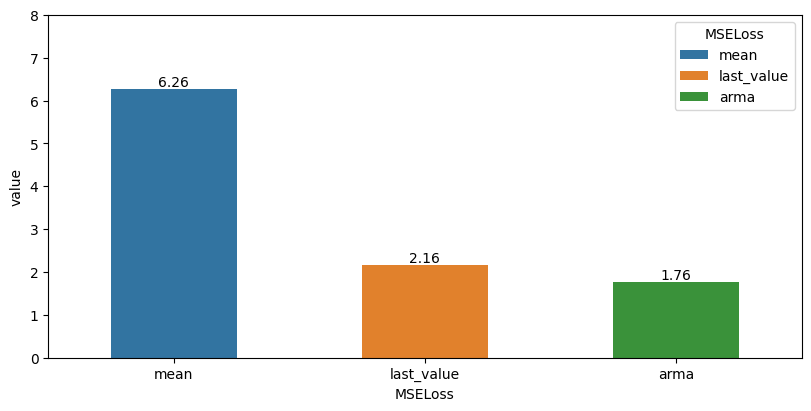

In [97]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([loss]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 8)
ax.set_xlabel('MSELoss')
ax.legend(title='MSELoss')
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)